# Camera position optimization using differentiable rendering

In [1]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PerspectiveCameras
)

### Load point cloud

In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
obj_filename = "./data/PittsburghBridge/pointcloud.npz"
# obj_filename = "./final_cost_cloud.npz"
obj_filename = "../../../../catkin_ws/src/frontier_exploration/pts/cam_pts_camera_0_1607456663.5413494.npz"

# Load point cloud
pts_np = np.load(obj_filename)['pts'].transpose()
# verts = torch.Tensor(pointcloud['verts']).to(device)
verts = torch.Tensor(pts_np).to(device)
        
#rgb = torch.Tensor(pointcloud['rgb']).to(device)
rgb = (verts - torch.min(verts)) / torch.max(verts - torch.min(verts)).to(device)
# rgb = torch.zeros((verts.size()[0], 3)).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

### Create a renderer

In [3]:
# Initialize a camera.
R = torch.eye(3).unsqueeze(0).to(device)
T = torch.Tensor([[0., 0., 0.]]).to(device)

cam_info_K = (758.03967, 0.0, 621.46572, 0.0, 761.62359, 756.86402, 0.0, 0.0, 1.0)
width, height = 1232, 1616

K = torch.zeros([4, 4]).to(device)
K[0][0] = cam_info_K[0]
K[0][2] = cam_info_K[2]
K[1][1] = cam_info_K[4]
K[1][2] = cam_info_K[5]
K[2][2] = 1
K[3][3] = 1
K = K.unsqueeze(0)

cameras = PerspectiveCameras(device=device, R=R, T=T, K=K)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=1024, #(width, height), 
    radius=0.003,
    points_per_pixel=10
)

rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PulsarPointsRenderer(
    rasterizer=rasterizer,
    n_channels=3
).to(device)

### Reference point cloud view rendering

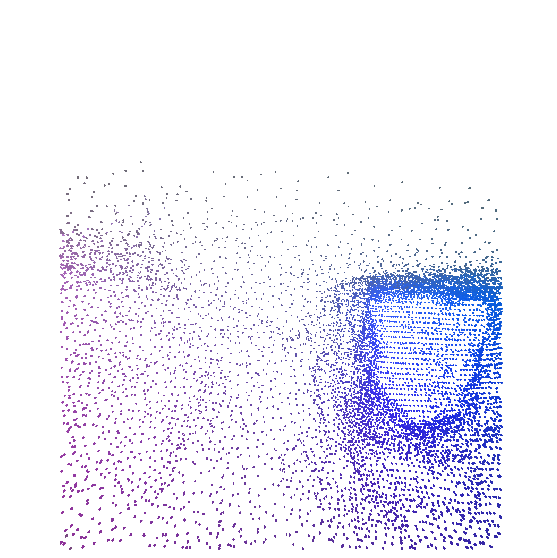

In [4]:
image_ref = renderer(
    point_cloud,
    gamma=(1.0e-1,),  # Renderer blending parameter gamma, in [1., 1e-5].
    znear=(1.0,),
    zfar=(15.0,),
    bg_col=torch.ones((3,), dtype=torch.float32, device=device),
)[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_ref[..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")
plt.show()

# plot_scene({
#     "Pointcloud": {
#         "person": point_cloud
#     }
# })

### Points visibility estimation

In [5]:
import sys
sys.path.append('../')
from src.tools import hidden_pts_removal

pts_np_visible = hidden_pts_removal(pts_np)
print(f'Original pc verts: {np.max(pts_np.shape)}. Visible pc verts: {np.max(pts_np_visible.shape)}')

verts_visible = torch.Tensor(pts_np_visible).to(device)

rgb_visible = verts_visible - torch.min(verts_visible)
rgb_visible = rgb_visible / torch.max(rgb_visible).to(device)

point_cloud_visible = Pointclouds(points=[verts_visible], features=[rgb_visible])

point_cloud_batch = Pointclouds(points=[verts, verts_visible], features=[rgb, rgb_visible])

fig2 = plot_batch_individually(point_cloud_batch, ncols=2, viewpoint_cameras=cameras)
fig2.show()

Original pc verts: 8811. Visible pc verts: 3658


### Create initial image

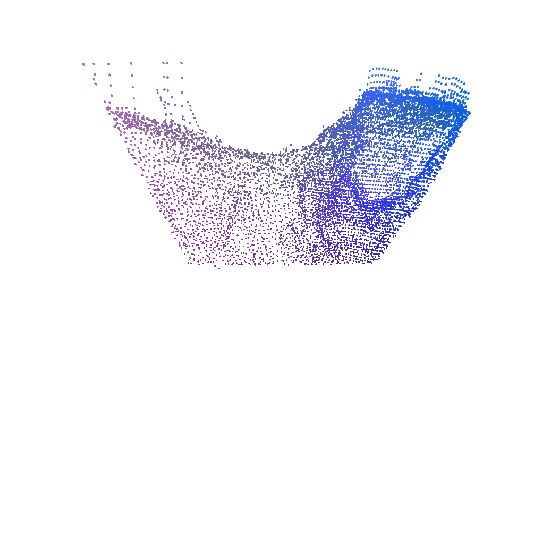

In [6]:
# Select the viewpoint using spherical angles  
distance = -3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

cameras = PerspectiveCameras(device=device, R=R, T=T, K=K)

renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=3
).to(device)

image_init = renderer(
    point_cloud,
    gamma=torch.tensor([1.0e-1]),  # Renderer blending parameter gamma, in [1., 1e-5].
    znear=torch.tensor([1.0]),
    zfar=torch.tensor([15.0]),
    bg_col=torch.ones((3,), dtype=torch.float32, device=device),
)[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_init[..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")
plt.show()

# plot_scene({
#     "Pointcloud": {
#         "person": point_cloud
#     }
# })

### Set up a basic model 

Here we create a simple model class and initialize a parameter for the camera position. 

In [7]:
class Model(nn.Module):
    def __init__(self, points, raster_settings, image_ref):
        super().__init__()
        self.points = points
        self.device = points.device
        self.raster_settings = raster_settings
        self.renderer = None
        self.gamma=nn.Parameter(torch.tensor([1.0e-1]).to(points.device))  # Renderer blending parameter gamma, in [1., 1e-5].
        self.znear=nn.Parameter(torch.tensor([1.0]).to(points.device))
        self.zfar=nn.Parameter(torch.tensor([15.0]).to(points.device))
        self.bg_col=torch.ones((3,), dtype=torch.float32, device=points.device)
                          
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        # image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        image_ref = torch.as_tensor(image_ref[..., :3], dtype=torch.float32)
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(points.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        cameras = PerspectiveCameras(R=R, T=T, K=K, device=self.device)

        self.renderer = PulsarPointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=self.raster_settings),
            n_channels=3
        ).to(self.device)
        
        images = self.renderer(self.points.clone(),
                           gamma=self.gamma,
                           znear=self.znear,
                           zfar=self.zfar,
                           bg_col=self.bg_col,
                          )
        
        # Calculate the silhouette loss
        loss = torch.mean((images[0] - self.image_ref) ** 2)
        return loss, images

## 3. Initialize the model and optimizer

Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter. 

In [8]:
# We will save images periodically and compose them into a GIF.
# filename_output = "./teapot_optimization_demo.gif"
# writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(points=point_cloud, raster_settings=raster_settings, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [9]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([0.1000], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([15.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.0000, 6.9000, 2.5000], device='cuda:0', requires_grad=True)


### Visualize the starting position and the reference position

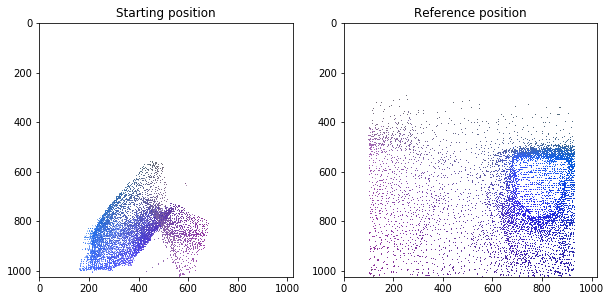

In [10]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy())
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference position");


## 4. Run the optimization 

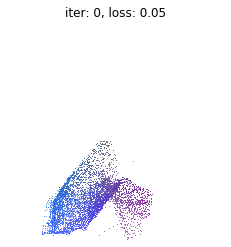

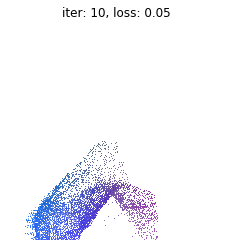

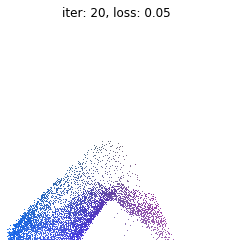

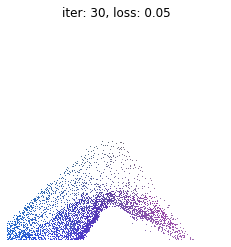

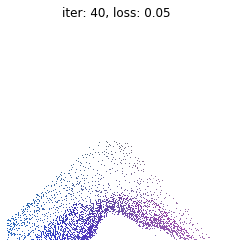

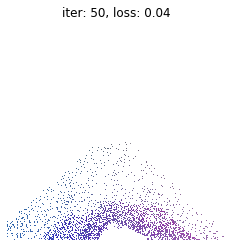

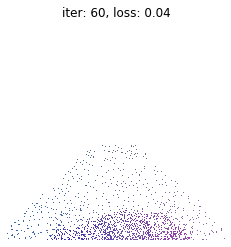

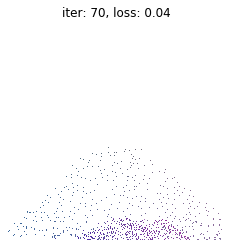

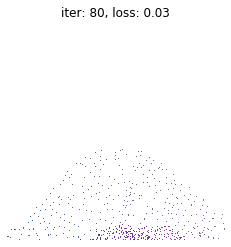

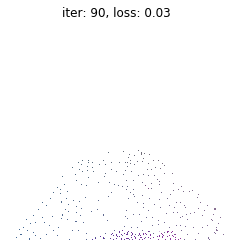

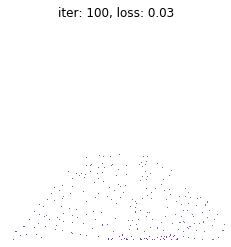

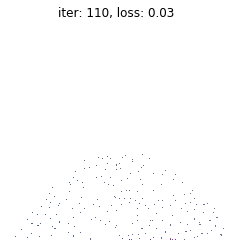

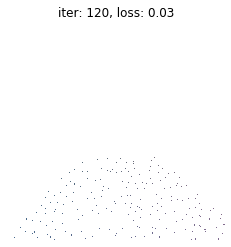

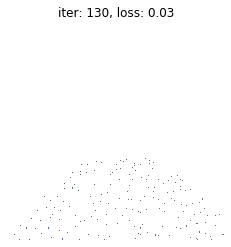

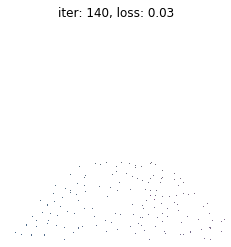

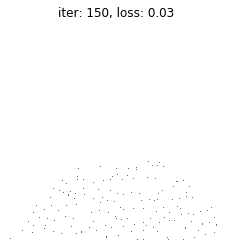

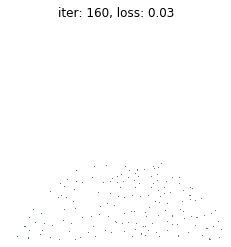

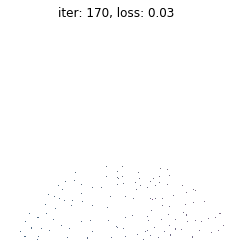

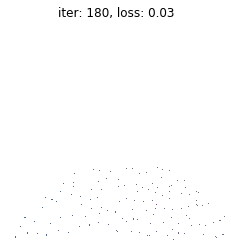

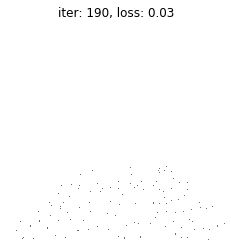

In [11]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
#     if loss.item() < 200:
#         break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = model.renderer(model.points.clone(),
                 gamma=torch.tensor([1.0e-1]),  # Renderer blending parameter gamma, in [1., 1e-5].
                 znear=torch.tensor([1.0]),
                 zfar=torch.tensor([15.0]),
                 bg_col=torch.ones((3,), dtype=torch.float32, device=device),
                 )
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
